# Fake Review Detection on Yelp Data set 
### Feature extraction 
### KNN



Loading the necessary Libraries

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('vader_lexicon')
import re;
nltk.download('brown')
nltk.download('punkt')
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading data from google drive

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 19.1MB/s 


In [0]:
link = "https://drive.google.com/open?id=1a8hdz_EP8FDscPqHHHGMGMXBdMNBOUmY"
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('metadata.tsv')  
metadata = pd.read_csv('metadata.tsv' , sep = '\t', header = 0)

1a8hdz_EP8FDscPqHHHGMGMXBdMNBOUmY


In [0]:
metadata.info()
metadata.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359052 entries, 0 to 359051
Data columns (total 5 columns):
User Id       359052 non-null int64
Product Id    359052 non-null int64
Rating        359052 non-null int64
Label         359052 non-null int64
Date          359052 non-null object
dtypes: int64(4), object(1)
memory usage: 13.7+ MB


,User Id,Product Id,Rating,Label,Date
0,923,0,3,-1,08-12-2014
1,924,0,3,-1,16-05-2013
2,925,0,4,-1,01-07-2013
3,926,0,4,-1,28-07-2011
4,927,0,4,-1,01-11-2010


In [0]:
link = "https://drive.google.com/open?id=1WyDdzVO2Ps93eY3BMJf4-oyeWi7ZRW42"
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('productIdMapping.tsv')  
ProdIdMap =pd.read_csv("productIdMapping.tsv", sep = '\t', header = 0)

1WyDdzVO2Ps93eY3BMJf4-oyeWi7ZRW42


In [0]:
ProdIdMap.info()
ProdIdMap.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 2 columns):
Product_Name    923 non-null object
Prod_Id         923 non-null int64
dtypes: int64(1), object(1)
memory usage: 14.5+ KB


,Product_Name,Prod_Id
0,Snack,0
1,Peppino’s,1
2,Dekalb Restaurant,3
3,Le Parisien,4
4,Blue Spoon Coffee,5


In [0]:
link = "https://drive.google.com/open?id=1qf_XRN-d2phMxy22vsx-RzOiP0Jw--lh"
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('reviewContent.tsv')
review = pd.read_csv("reviewContent.tsv", sep = '\t', header = 0)

1qf_XRN-d2phMxy22vsx-RzOiP0Jw--lh


In [0]:
review.info()
review.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358957 entries, 0 to 358956
Data columns (total 4 columns):
User Id       358957 non-null int64
Product Id    358957 non-null int64
Date          358957 non-null object
Review        358957 non-null object
dtypes: int64(2), object(2)
memory usage: 11.0+ MB


,User Id,Product Id,Date,Review
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...
1,924,0,16-05-2013,This little place in Soho is wonderful. I had ...
2,925,0,01-07-2013,ordered lunch for 15 from Snack last Friday. ...
3,926,0,28-07-2011,This is a beautiful quaint little restaurant o...
4,927,0,01-11-2010,Snack is great place for a casual sit down lu...


In [0]:
rev_col  = ['User_Id', 'Prod_Id']

In [0]:
metadata.head(5)

,User Id,Product Id,Rating,Label,Date
0,923,0,3,-1,08-12-2014
1,924,0,3,-1,16-05-2013
2,925,0,4,-1,01-07-2013
3,926,0,4,-1,28-07-2011
4,927,0,4,-1,01-11-2010


In [0]:
metadata.rename(index=str, columns={"User Id": "User_Id", "Product Id": "Prod_Id"}, inplace = True)

In [0]:
review.rename(index=str, columns={"User Id": "User_Id", "Product Id": "Prod_Id"}, inplace = True)

In [0]:
review.head(5)

,User_Id,Prod_Id,Date,Review
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...
1,924,0,16-05-2013,This little place in Soho is wonderful. I had ...
2,925,0,01-07-2013,ordered lunch for 15 from Snack last Friday. ...
3,926,0,28-07-2011,This is a beautiful quaint little restaurant o...
4,927,0,01-11-2010,Snack is great place for a casual sit down lu...


In [0]:
sampl = review.merge(metadata, how = 'left', left_on = rev_col, right_on=rev_col)

In [0]:
ProdIdMap.head(5)

,Product_Name,Prod_Id
0,Snack,0
1,Peppino’s,1
2,Dekalb Restaurant,3
3,Le Parisien,4
4,Blue Spoon Coffee,5


In [0]:
final = pd.merge(sampl, ProdIdMap, on = 'Prod_Id')

Getting our merged dataset from different files

In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Date_y,Product_Name
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,08-12-2014,Snack
1,924,0,16-05-2013,This little place in Soho is wonderful. I had ...,3,-1,16-05-2013,Snack
2,925,0,01-07-2013,ordered lunch for 15 from Snack last Friday. ...,4,-1,01-07-2013,Snack
3,926,0,28-07-2011,This is a beautiful quaint little restaurant o...,4,-1,28-07-2011,Snack
4,927,0,01-11-2010,Snack is great place for a casual sit down lu...,4,-1,01-11-2010,Snack


In [0]:
final.drop(columns='Date_y', inplace=True)

In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Product_Name
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,Snack
1,924,0,16-05-2013,This little place in Soho is wonderful. I had ...,3,-1,Snack
2,925,0,01-07-2013,ordered lunch for 15 from Snack last Friday. ...,4,-1,Snack
3,926,0,28-07-2011,This is a beautiful quaint little restaurant o...,4,-1,Snack
4,927,0,01-11-2010,Snack is great place for a casual sit down lu...,4,-1,Snack


(array([ 14222.,      0.,  20774.,      0.,      0.,  47631.,      0.,
        135202.,      0., 141128.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

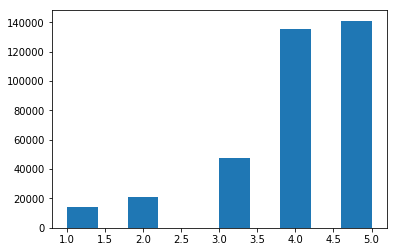

In [0]:
plt.hist(data=final, x=final.Rating, bins=10)

We can see that the data is right skewed, Lets the the average ratings per restaurant

In [0]:
average_rating_per_product = final.groupby('Product_Name')['Rating'].mean()

In [0]:
average_rating_per_product.head()

Product_Name
10 Devoe                      4.863636
100 Montaditos                3.981221
983-Bushwick’s Living Room    3.896739
99 Favor Taste                3.993610
A Little Taste                4.782609
Name: Rating, dtype: float64

In [0]:
average_rating_per_product =  average_rating_per_product.to_frame()

In [0]:
average_rating_per_product.head()

,Rating
Product_Name,
10 Devoe,4.863636
100 Montaditos,3.981221
983-Bushwick’s Living Room,3.896739
99 Favor Taste,3.993610
A Little Taste,4.782609


In [0]:
average_rating_per_product.reset_index(level=0, inplace=True)

Adding feature in existing dataset of average rating of the product.

In [0]:
average_rating_per_product = average_rating_per_product.rename(columns={'Rating':'Avg_Prod_Rating'})

In [0]:
average_rating_per_product.head()

,Product_Name,Avg_Prod_Rating
0,10 Devoe,4.863636
1,100 Montaditos,3.981221
2,983-Bushwick’s Living Room,3.896739
3,99 Favor Taste,3.993610
4,A Little Taste,4.782609


In [0]:
final = final.merge(average_rating_per_product, left_on='Product_Name', right_on='Product_Name')

In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Product_Name,Avg_Prod_Rating
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,Snack,4.009524
1,924,0,16-05-2013,This little place in Soho is wonderful. I had ...,3,-1,Snack,4.009524
2,925,0,01-07-2013,ordered lunch for 15 from Snack last Friday. ...,4,-1,Snack,4.009524
3,926,0,28-07-2011,This is a beautiful quaint little restaurant o...,4,-1,Snack,4.009524
4,927,0,01-11-2010,Snack is great place for a casual sit down lu...,4,-1,Snack,4.009524


Lets add feature of average rating that the user gives for comparison

In [0]:
average_rating_per_user = final.groupby('User_Id')['Rating'].mean()

In [0]:
average_rating_per_user = average_rating_per_user.to_frame()

In [0]:
average_rating_per_user.reset_index(level=0, inplace=True)

In [0]:
average_rating_per_user.head()

,User_Id,Rating
0,923,4.435897
1,924,3.000000
2,925,4.000000
3,926,4.000000
4,927,3.600000


In [0]:
average_rating_per_user = average_rating_per_user.rename(columns={'Rating':'Avg_user_rating'})

In [0]:
average_rating_per_user.head()

,User_Id,Avg_user_rating
0,923,4.435897
1,924,3.000000
2,925,4.000000
3,926,4.000000
4,927,3.600000


In [0]:
final = final.merge(average_rating_per_user, left_on='User_Id', right_on='User_Id')

In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Product_Name,Avg_Prod_Rating,Avg_user_rating
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,Snack,4.009524,4.435897
1,923,19,14-01-2014,The restaurant is on the ground floor of a typ...,5,-1,Palo Santo,4.037152,4.435897
2,923,40,30-05-2014,Really nice mousaka and lovely décor inside. A...,4,-1,Pylos,4.312869,4.435897
3,923,63,13-11-2014,I really enjoyed brunch at Jane. The ambiance ...,4,-1,Jane,3.937181,4.435897
4,923,79,30-03-2014,We ate at the Blue Ribbon with colleagues. The...,3,-1,Blue Ribbon Brasserie,4.280000,4.435897


In [0]:
final.describe()

,User_Id,Prod_Id,Rating,Label,Avg_Prod_Rating,Avg_user_rating
count,358957.000000,358957.000000,358957.000000,358957.000000,358957.000000,358957.000000
mean,53997.215187,459.989378,4.025861,0.794627,4.025861,4.025861
std,45808.754776,259.913081,1.055113,0.607099,0.218212,0.811565
min,923.000000,0.000000,1.000000,-1.000000,2.984163,1.000000
25%,13840.000000,247.000000,4.000000,1.000000,3.872340,3.739130
50%,40532.000000,468.000000,4.000000,1.000000,3.990777,4.000000
75%,87321.000000,672.000000,5.000000,1.000000,4.157591,4.500000
max,161147.000000,922.000000,5.000000,1.000000,4.944444,5.000000


In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Product_Name,Avg_Prod_Rating,Avg_user_rating
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,Snack,4.009524,4.435897
1,923,19,14-01-2014,The restaurant is on the ground floor of a typ...,5,-1,Palo Santo,4.037152,4.435897
2,923,40,30-05-2014,Really nice mousaka and lovely décor inside. A...,4,-1,Pylos,4.312869,4.435897
3,923,63,13-11-2014,I really enjoyed brunch at Jane. The ambiance ...,4,-1,Jane,3.937181,4.435897
4,923,79,30-03-2014,We ate at the Blue Ribbon with colleagues. The...,3,-1,Blue Ribbon Brasserie,4.280000,4.435897


Extracting Review length from dataset

In [0]:
final['Review_Len']= final['Review '].apply(len)

In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Product_Name,Avg_Prod_Rating,Avg_user_rating,Review_Len
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,Snack,4.009524,4.435897,215
1,923,19,14-01-2014,The restaurant is on the ground floor of a typ...,5,-1,Palo Santo,4.037152,4.435897,513
2,923,40,30-05-2014,Really nice mousaka and lovely décor inside. A...,4,-1,Pylos,4.312869,4.435897,231
3,923,63,13-11-2014,I really enjoyed brunch at Jane. The ambiance ...,4,-1,Jane,3.937181,4.435897,169
4,923,79,30-03-2014,We ate at the Blue Ribbon with colleagues. The...,3,-1,Blue Ribbon Brasserie,4.280000,4.435897,255


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0fe337f668>,
      dtype=object)

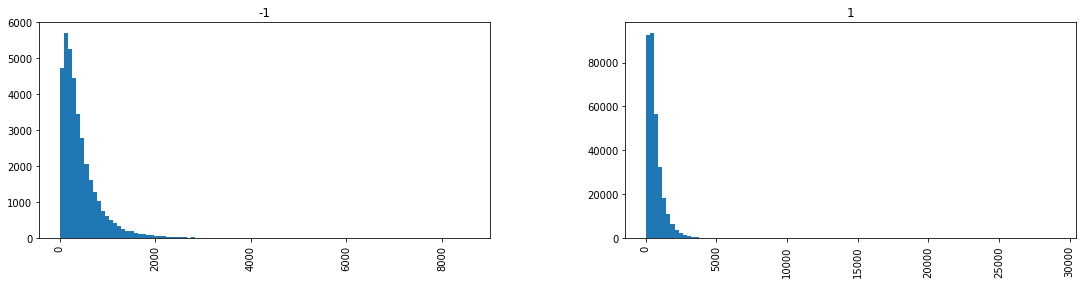

In [0]:
final.hist(column='Review_Len', by = 'Label', bins=100, figsize=(18,4))


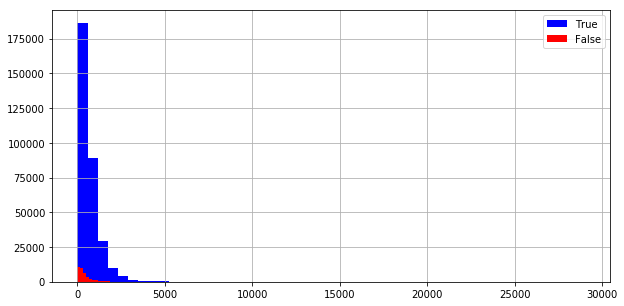

In [0]:
plt.figure(figsize=[10,5])
final[final['Label'] == 1]['Review_Len'].hist(bins=50, label='True', color='blue')
final[final['Label'] == -1]['Review_Len'].hist(bins=50, label='False', color='red')
plt.legend()

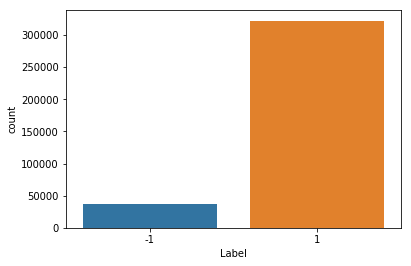

In [0]:
sns.countplot(final['Label'])

We can see that our data is highly imbalanced, we need to understand how to handle unbalanced data

In [0]:
final.groupby('Label')['Review_Len'].mean()

Label
-1    442.331091
 1    657.238257
Name: Review_Len, dtype: float64

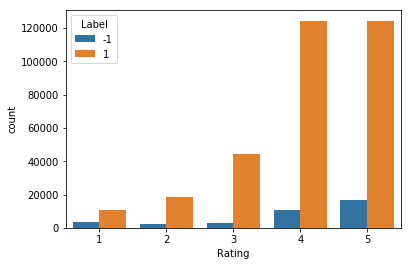

In [0]:
sns.countplot(data=final, x='Rating', hue='Label')

Word Cloud for Fake Reviews

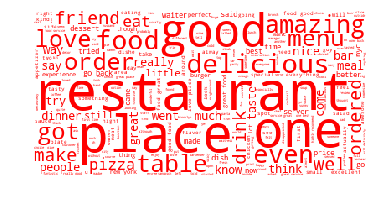

In [0]:
word_string=" ".join(final[final['Label']==-1]['Review '].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=300, color_func=(lambda *args, **kwargs: (255,0,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Word Cloud for True Reviews

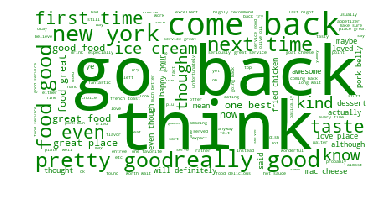

<Figure size 864x288 with 0 Axes>

In [0]:
word_string=" ".join(final[final['Label']==1]['Review '].str.lower())
wordcloud_false = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=300, color_func=(lambda *args, **kwargs: (0,128,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud_false)
plt.axis('off')
plt.figure(figsize=[12,4])
plt.show()

Extracting total reviews for a user to identify his review pattern

In [0]:
user_total_reviews=final.groupby('User_Id').count()['Label']

In [0]:
user_total_reviews = user_total_reviews.to_frame()

In [0]:
user_total_reviews.head()

,Label
User_Id,
923,39
924,1
925,2
926,1
927,5


In [0]:
user_total_reviews.reset_index(level=0, inplace=True)

In [0]:
user_total_reviews =  user_total_reviews.rename(columns={'Label':'user_total_reviews'})

In [0]:
final = final.merge(user_total_reviews, how='outer')

In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Product_Name,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,Snack,4.009524,4.435897,215,39
1,923,19,14-01-2014,The restaurant is on the ground floor of a typ...,5,-1,Palo Santo,4.037152,4.435897,513,39
2,923,40,30-05-2014,Really nice mousaka and lovely décor inside. A...,4,-1,Pylos,4.312869,4.435897,231,39
3,923,63,13-11-2014,I really enjoyed brunch at Jane. The ambiance ...,4,-1,Jane,3.937181,4.435897,169,39
4,923,79,30-03-2014,We ate at the Blue Ribbon with colleagues. The...,3,-1,Blue Ribbon Brasserie,4.280000,4.435897,255,39


Loading data file given by team members with clean review corpus

In [0]:
link = "https://drive.google.com/open?id=1vZh8hBkdXjN1cf52p6G3pkyfi5lHaYly"
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('latest_tsv.tsv')  
review_cleaned =pd.read_csv("latest_tsv.tsv", sep = '\t', header = 0)

1vZh8hBkdXjN1cf52p6G3pkyfi5lHaYly


In [0]:
review_cleaned.head()

,User_Id,Prod_Id,Date,Review_Text,Rating,Label,Date,Product Name,text length,corpus
0,923,0,12/8/2014,The food at snack is a selection of popular Gr...,3,-1,12/8/2014,Snack,215,food snack select popular greek dish appet tra...
1,924,0,5/16/2013,This little place in Soho is wonderful. I had ...,3,-1,5/16/2013,Snack,269,littl place soho wonder lamb sandwich glass wi...
2,925,0,7/1/2013,ordered lunch for 15 from Snack last Friday. ...,4,-1,7/1/2013,Snack,178,order lunch snack last friday time noth miss f...
3,926,0,7/28/2011,This is a beautiful quaint little restaurant o...,4,-1,7/28/2011,Snack,491,beauti quaint littl restaur pretti street stro...
4,927,0,11/1/2010,Snack is great place for a casual sit down lu...,4,-1,11/1/2010,Snack,596,snack great place casual sit lunch especi cold...


In [0]:
review_cleaned.shape

(358957, 10)

Adding corpus in our final data from cleaned data

In [0]:
final['corpus'] = review_cleaned['corpus']

In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Product_Name,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,Snack,4.009524,4.435897,215,39,food snack select popular greek dish appet tra...
1,923,19,14-01-2014,The restaurant is on the ground floor of a typ...,5,-1,Palo Santo,4.037152,4.435897,513,39,littl place soho wonder lamb sandwich glass wi...
2,923,40,30-05-2014,Really nice mousaka and lovely décor inside. A...,4,-1,Pylos,4.312869,4.435897,231,39,order lunch snack last friday time noth miss f...
3,923,63,13-11-2014,I really enjoyed brunch at Jane. The ambiance ...,4,-1,Jane,3.937181,4.435897,169,39,beauti quaint littl restaur pretti street stro...
4,923,79,30-03-2014,We ate at the Blue Ribbon with colleagues. The...,3,-1,Blue Ribbon Brasserie,4.280000,4.435897,255,39,snack great place casual sit lunch especi cold...


In [0]:
final = final.dropna()

In [0]:
def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [0]:
review_sentiment=  final['corpus']

Extracting sentiment from our review corpus 

In [0]:
review_sentiment.head()

0    food snack select popular greek dish appet tra...
1    littl place soho wonder lamb sandwich glass wi...
2    order lunch snack last friday time noth miss f...
3    beauti quaint littl restaur pretti street stro...
4    snack great place casual sit lunch especi cold...
Name: corpus, dtype: object

In [0]:
nltk_results = [nltk_sentiment(row) for row in review_sentiment]
results_df = pd.DataFrame(nltk_results)


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
nltk_df = review_sentiment.to_frame().join(results_df)

In [0]:
nltk_df.head()

,corpus,compound,neg,neu,pos
0,food snack select popular greek dish appet tra...,0.6486,0.061,0.693,0.247
1,littl place soho wonder lamb sandwich glass wi...,-0.1280,0.189,0.673,0.138
2,order lunch snack last friday time noth miss f...,0.7717,0.067,0.628,0.305
3,beauti quaint littl restaur pretti street stro...,0.8910,0.042,0.712,0.246
4,snack great place casual sit lunch especi cold...,0.9769,0.000,0.661,0.339


Merging our sentiment score for reviews with final dataset

In [0]:
final = final.merge(nltk_df)

In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Product_Name,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus,compound,neg,neu,pos
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,Snack,4.009524,4.435897,215,39,food snack select popular greek dish appet tra...,0.6486,0.061,0.693,0.247
1,923,19,14-01-2014,The restaurant is on the ground floor of a typ...,5,-1,Palo Santo,4.037152,4.435897,513,39,littl place soho wonder lamb sandwich glass wi...,-0.1280,0.189,0.673,0.138
2,923,40,30-05-2014,Really nice mousaka and lovely décor inside. A...,4,-1,Pylos,4.312869,4.435897,231,39,order lunch snack last friday time noth miss f...,0.7717,0.067,0.628,0.305
3,923,63,13-11-2014,I really enjoyed brunch at Jane. The ambiance ...,4,-1,Jane,3.937181,4.435897,169,39,beauti quaint littl restaur pretti street stro...,0.8910,0.042,0.712,0.246
4,923,79,30-03-2014,We ate at the Blue Ribbon with colleagues. The...,3,-1,Blue Ribbon Brasserie,4.280000,4.435897,255,39,snack great place casual sit lunch especi cold...,0.9769,0.000,0.661,0.339


Function to help us extract count of regex patterns from review text

In [0]:
def count_regex(pattern, row):
  return len(re.findall(pattern, row))

Extracting count of capital words

In [0]:
count_capital_words = final['Review '].apply(lambda x: count_regex(r'\b[A-Z]{2,}\b', x))
final['number_Cap_Words'] = count_capital_words.to_frame();

Extracting count of digits in review

In [0]:
count_digit_words = final['Review '].apply(lambda x: count_regex(r'\b[0-9]{2,}\b', x))
final['number_digit_Words'] = count_digit_words.to_frame();

In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Product_Name,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus,compound,neg,neu,pos,number_Cap_Words,number_digit_Words
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,Snack,4.009524,4.435897,215,39,food snack select popular greek dish appet tra...,0.6486,0.061,0.693,0.247,0,0
1,923,19,14-01-2014,The restaurant is on the ground floor of a typ...,5,-1,Palo Santo,4.037152,4.435897,513,39,littl place soho wonder lamb sandwich glass wi...,-0.1280,0.189,0.673,0.138,0,0
2,923,40,30-05-2014,Really nice mousaka and lovely décor inside. A...,4,-1,Pylos,4.312869,4.435897,231,39,order lunch snack last friday time noth miss f...,0.7717,0.067,0.628,0.305,0,1
3,923,63,13-11-2014,I really enjoyed brunch at Jane. The ambiance ...,4,-1,Jane,3.937181,4.435897,169,39,beauti quaint littl restaur pretti street stro...,0.8910,0.042,0.712,0.246,0,0
4,923,79,30-03-2014,We ate at the Blue Ribbon with colleagues. The...,3,-1,Blue Ribbon Brasserie,4.280000,4.435897,255,39,snack great place casual sit lunch especi cold...,0.9769,0.000,0.661,0.339,0,0


Function to count noun phrases in review text

In [0]:
def identify_noun_count(sentence):
  blob = TextBlob(sentence)
  return len(blob.noun_phrases)

Extracting noun count from our review text

In [0]:
final['noun_count'] = final['Review '].apply(identify_noun_count)

In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Product_Name,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus,compound,neg,neu,pos,number_Cap_Words,number_digit_Words,noun_count
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,Snack,4.009524,4.435897,215,39,food snack select popular greek dish appet tra...,0.6486,0.061,0.693,0.247,0,0,3
1,923,19,14-01-2014,The restaurant is on the ground floor of a typ...,5,-1,Palo Santo,4.037152,4.435897,513,39,littl place soho wonder lamb sandwich glass wi...,-0.1280,0.189,0.673,0.138,0,0,9
2,923,40,30-05-2014,Really nice mousaka and lovely décor inside. A...,4,-1,Pylos,4.312869,4.435897,231,39,order lunch snack last friday time noth miss f...,0.7717,0.067,0.628,0.305,0,1,4
3,923,63,13-11-2014,I really enjoyed brunch at Jane. The ambiance ...,4,-1,Jane,3.937181,4.435897,169,39,beauti quaint littl restaur pretti street stro...,0.8910,0.042,0.712,0.246,0,0,2
4,923,79,30-03-2014,We ate at the Blue Ribbon with colleagues. The...,3,-1,Blue Ribbon Brasserie,4.280000,4.435897,255,39,snack great place casual sit lunch especi cold...,0.9769,0.000,0.661,0.339,0,0,3


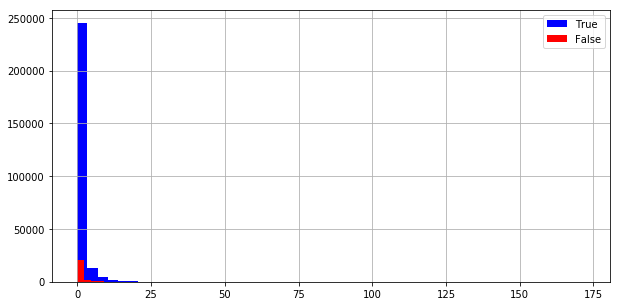

In [0]:
plt.figure(figsize=[10,5])
final[(final['Label'] == 1) & (final['noun_count'] > 4)]['number_Cap_Words'].hist(bins=50, label='True', color='blue')
final[(final['Label'] == -1) & (final['noun_count'] > 4)]['number_Cap_Words'].hist(bins=50, label='False', color='red')
plt.legend()

Correlation matrix for our numerical data 

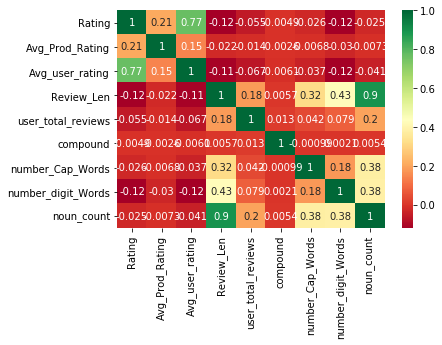

In [0]:
#correlation matrix
final_corr_data = sns.heatmap(final[['Rating','Avg_Prod_Rating','Avg_user_rating','Review_Len','user_total_reviews','compound','number_Cap_Words','number_digit_Words','noun_count']].corr(),annot=True,cmap="RdYlGn")

Finding Common words from the corpus

In [0]:
positive = final[final['Label']== 1]
true_word_list = []
for i in range(0,positive['corpus'].count()):
   true_word_temp = positive['corpus'].iloc[i].split()
   true_word_list.append(true_word_temp)
from itertools import chain
list1 = list(chain.from_iterable(true_word_list))
from collections import Counter 
true_mc = Counter(list1).most_common()
 
 
fake = final[final['Label'] == -1]
fake_word_list= fake['corpus'].str.split(expand=True).stack()
from collections import Counter 
fake_mc = Counter(fake_word_list).most_common() 
 
df_true = pd.DataFrame(true_mc)
df_false = pd.DataFrame(fake_mc)
df_false1 = df_false[0:23]
df_true1 = df_true[0:23]
df_common = list(set(df_true1.iloc[:,0]) & set(df_false1.iloc[:,0]))
df_common

['best',
 'would',
 'delici',
 'time',
 'like',
 'place',
 'tri',
 'back',
 'also',
 'good',
 'restaur',
 'love',
 'order',
 'wait',
 'food',
 'realli',
 'great',
 'go',
 'come',
 'one',
 'get',
 'servic']

In [0]:
final.head()

,User_Id,Prod_Id,Date_x,Review,Rating,Label,Product_Name,Avg_Prod_Rating,Avg_user_rating,Review_Len,user_total_reviews,corpus,compound,neg,neu,pos,number_Cap_Words,number_digit_Words,noun_count
0,923,0,08-12-2014,The food at snack is a selection of popular Gr...,3,-1,Snack,4.009524,4.435897,215,39,food snack select popular greek dish appet tra...,0.6486,0.061,0.693,0.247,0,0,3
1,923,19,14-01-2014,The restaurant is on the ground floor of a typ...,5,-1,Palo Santo,4.037152,4.435897,513,39,littl place soho wonder lamb sandwich glass wi...,-0.1280,0.189,0.673,0.138,0,0,9
2,923,40,30-05-2014,Really nice mousaka and lovely décor inside. A...,4,-1,Pylos,4.312869,4.435897,231,39,order lunch snack last friday time noth miss f...,0.7717,0.067,0.628,0.305,0,1,4
3,923,63,13-11-2014,I really enjoyed brunch at Jane. The ambiance ...,4,-1,Jane,3.937181,4.435897,169,39,beauti quaint littl restaur pretti street stro...,0.8910,0.042,0.712,0.246,0,0,2
4,923,79,30-03-2014,We ate at the Blue Ribbon with colleagues. The...,3,-1,Blue Ribbon Brasserie,4.280000,4.435897,255,39,snack great place casual sit lunch especi cold...,0.9769,0.000,0.661,0.339,0,0,3


Separating predictor and target variables for our model

In [0]:
final_data_for_train =  final.drop(columns=['User_Id','Prod_Id','Date_x','Review ','Product_Name','compound'])

Dropping na values 

In [0]:
final_data_for_train =  final_data_for_train.dropna()
final = final.dropna()

Splitting our dataset into training and testing set

In [0]:
#Split
X_train, X_test, y_train, y_test = train_test_split(final_data_for_train, final['Label'], test_size=0.25, random_state=101)

#Vectorize
vectorizer = TfidfVectorizer(stop_words= df_common, ngram_range=(3,3), max_features= 15000)
vectorize = vectorizer.fit(X_train['corpus'])

In [0]:
X_train_vector = vectorize.transform(X_train['corpus'])
X_test_vector = vectorize.transform(X_test['corpus'])

In [0]:
final_train = sp.sparse.hstack((X_train_vector,X_train[['Rating','Avg_Prod_Rating','Avg_user_rating','Review_Len','user_total_reviews','neg','neu','pos','number_Cap_Words','number_digit_Words','noun_count']].values),format='csr')

In [0]:
final_test = sp.sparse.hstack((X_test_vector,X_test[['Rating','Avg_Prod_Rating','Avg_user_rating','Review_Len','user_total_reviews','neg','neu','pos','number_Cap_Words','number_digit_Words','noun_count']].values),format='csr')

K Nearest Neighbors

According to rule of thumb setting value of K = sqrt(n) where n is the number of samples(rows)

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(final_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(-1, 265849), (1, 265849)]


In [0]:
neighors = np.sqrt(X_resampled.shape[0])

In [0]:
neighors

729.1762475561036

In [108]:
knn = KNeighborsClassifier(n_neighbors=int(neighors))
knn.fit(X_resampled, y_resampled)
prediction_knn = knn.predict(final_test)

KeyboardInterrupt: ignored

In [0]:
print(classification_report(y_test, prediction_knn))
confusion_matrix(y_test, prediction_knn)

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, prediction_knn)
plot_roc_curve(fpr, tpr)

In [0]:
print(accuracy_score(y_test, prediction_knn))
print(roc_auc_score(y_test, prediction_knn))

Evaluation of our result

In [0]:
def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, prediction_knn)


In [0]:
plot_roc_curve(fpr, tpr)

In [0]:
accuracy_score(y_test, prediction_knn)

In [0]:
roc_auc_score(y_test, prediction_knn)

Random Forest Algorithm

In [0]:
#random forest
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_resampled,y_resampled)


In [1]:
prediction=clf.predict(final_test)

NameError: ignored

In [0]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, prediction))
confusion_matrix(y_test, prediction)